In [2]:
# --- 1) Setup ---
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from pathlib import Path

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
)

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

RANDOM_STATE = 42

In [3]:
DATA_PATH = Path("InsuranceCustomerdata.csv")  

df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head())


Shape: (200000, 12)


,Unnamed: 0,Customer Name,Customer_Address,Company Name,Claim Reason,Data confidentiality,Claim Amount,Category Premium,Premium/Amount Ratio,Claim Request output,BMI,Churn
0,0,Christine Payne,"7627 Anderson Rest Apt. 265,Lake Heather, DC 3...","Williams, Henderson and Perez",Travel,Low,377,4794,0.078640,No,21,Yes
1,1,Tony Fernandez,"3953 Cindy Brook Apt. 147,East Lindatown, TN 4...",Moore-Goodwin,Medical,High,1440,14390,0.100069,No,24,Yes
2,2,Christopher Kim,"8693 Walters Mountains,South Tony, TX 88407",Smith-Holmes,Phone,Medium,256,1875,0.136533,No,18,Yes
3,3,Nicole Allen,"56926 Webster Coves,Shawnmouth, NV 04853",Harrell-Perez,Phone,Medium,233,1875,0.124267,No,24,Yes
4,4,Linda Cruz,"489 Thomas Forges Apt. 305,Jesseton, GA 36765","Simpson, Kramer and Hughes",Phone,Medium,239,1875,0.127467,No,21,Yes


In [4]:
print("\nColumns:")
print(df.columns.tolist())

# Normalize column names a bit (optional but helps avoid typos)
df.columns = [c.strip() for c in df.columns]

# Show missingness
missing = df.isna().mean().sort_values(ascending=False)
display(missing.to_frame("missing_rate"))

# Target distribution
target_col = "Churn"
if target_col not in df.columns:
    raise ValueError(f"Expected target column '{target_col}' not found. Found: {df.columns.tolist()}")

print("\nChurn distribution:")
display(df[target_col].value_counts(dropna=False).to_frame("count"))
display(df[target_col].value_counts(normalize=True, dropna=False).to_frame("rate"))



Columns:
['Unnamed: 0', 'Customer Name', 'Customer_Address', 'Company Name', 'Claim Reason', 'Data confidentiality', 'Claim Amount', 'Category Premium', 'Premium/Amount Ratio', 'Claim Request output', 'BMI', 'Churn']


,missing_rate
Unnamed: 0,0.0
Customer Name,0.0
Customer_Address,0.0
Company Name,0.0
Claim Reason,0.0
Data confidentiality,0.0
Claim Amount,0.0
Category Premium,0.0
Premium/Amount Ratio,0.0
Claim Request output,0.0



Churn distribution:


,count
Churn,
Yes,127272
No,72728


,rate
Churn,
Yes,0.63636
No,0.36364


In [5]:
data = df.copy()

DROP_COLS = [
    "Customer Name",
    "Customer_Address",
    "Company Name"
]

data = data.drop(columns=[c for c in DROP_COLS if c in data.columns], errors="ignore")

# Convert numerics
for col in ["Claim Amount", "Category Premium", "Premium/Amount Ratio", "BMI"]:
    if col in data.columns:
        data[col] = pd.to_numeric(data[col], errors="coerce")

# Normalize churn
if data["Churn"].dtype == "O":
    data["Churn"] = (
        data["Churn"].astype(str).str.lower().map({
            "1": 1, "0": 0, "yes": 1, "no": 0,
            "y": 1, "n": 0, "true": 1, "false": 0
        })
    )

data = data.dropna(subset=["Churn"])
print(data.head())

   Unnamed: 0 Claim Reason Data confidentiality  Claim Amount  \
0           0       Travel                  Low           377   
1           1      Medical                 High          1440   
2           2        Phone               Medium           256   
3           3        Phone               Medium           233   
4           4        Phone               Medium           239   

   Category Premium  Premium/Amount Ratio Claim Request output  BMI  Churn  
0              4794              0.078640                   No   21      1  
1             14390              0.100069                   No   24      1  
2              1875              0.136533                   No   18      1  
3              1875              0.124267                   No   24      1  
4              1875              0.127467                   No   21      1  


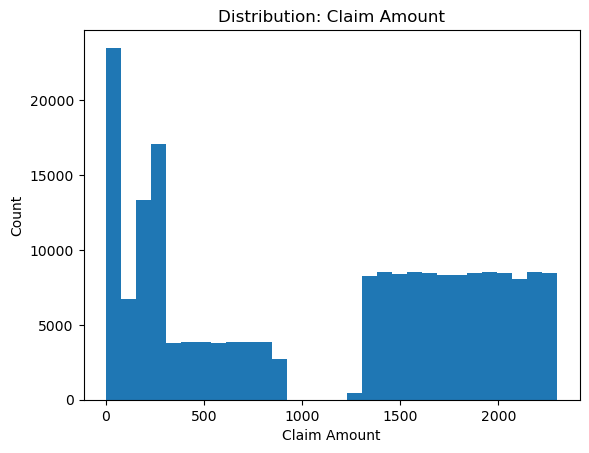

<Figure size 640x480 with 0 Axes>

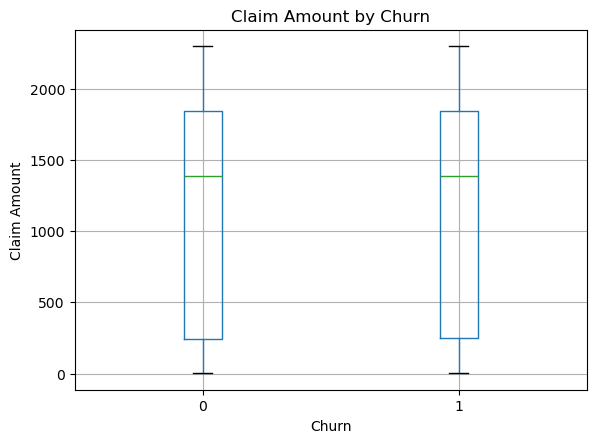

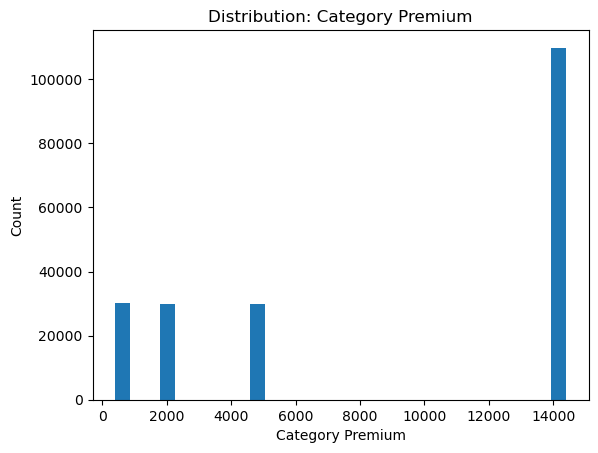

<Figure size 640x480 with 0 Axes>

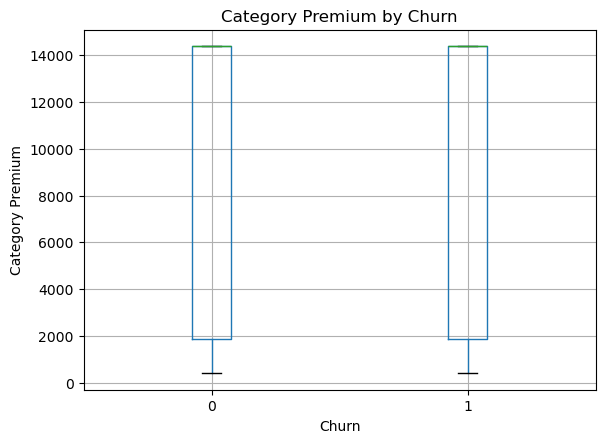

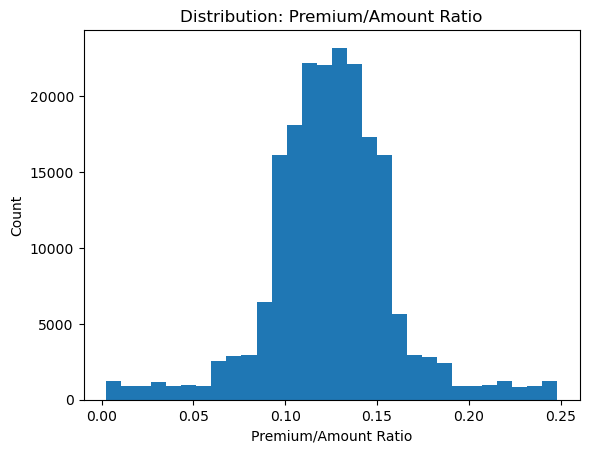

<Figure size 640x480 with 0 Axes>

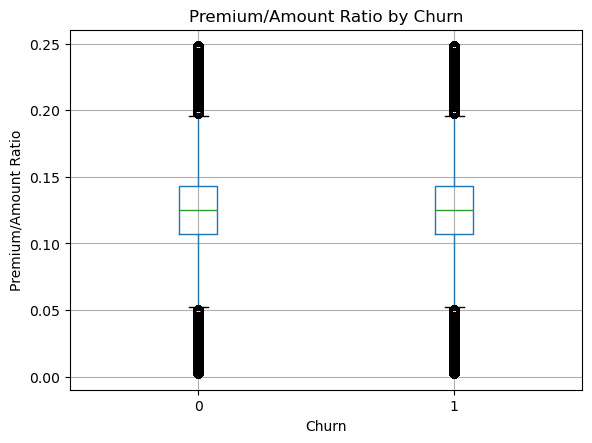

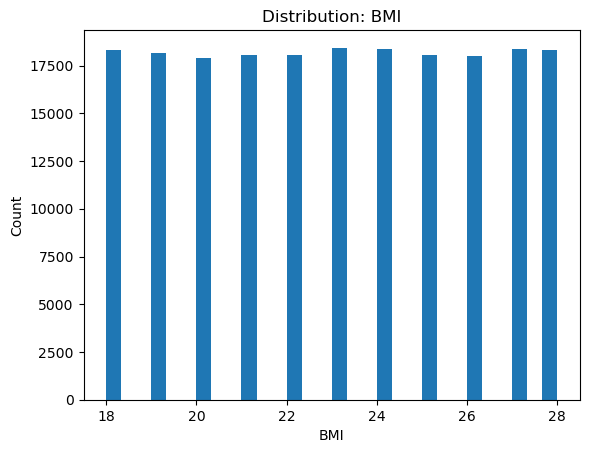

<Figure size 640x480 with 0 Axes>

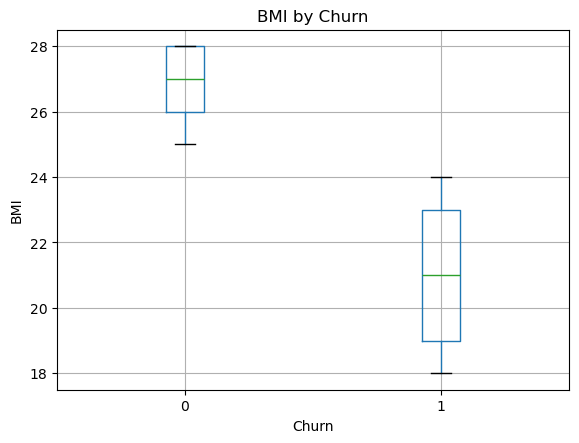

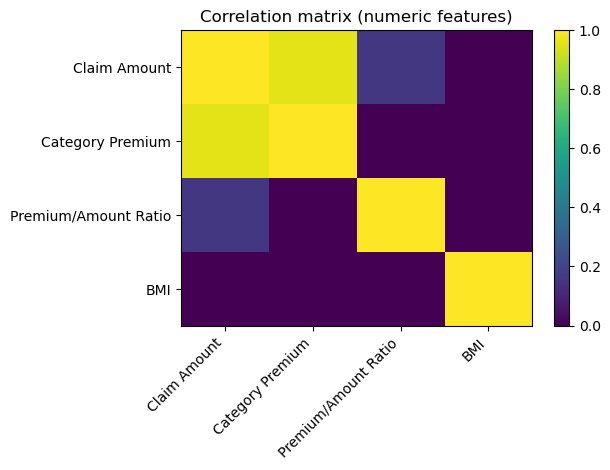

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,200000.0,NaN,NaN,NaN,99999.5,57735.171256,0.0,49999.75,99999.5,149999.25,199999.0
Claim Reason,200000,4,Medical,109863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Data confidentiality,200000,4,High,109863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Claim Amount,200000.0,NaN,NaN,NaN,1120.47884,796.660796,1.0,245.0,1390.0,1844.0,2299.0
Category Premium,200000.0,NaN,NaN,NaN,8963.783895,6114.737202,399.0,1875.0,14390.0,14390.0,14390.0
Premium/Amount Ratio,200000.0,NaN,NaN,NaN,0.125024,0.034742,0.002506,0.106741,0.125122,0.143155,0.24812
Claim Request output,200000,2,No,192994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BMI,200000.0,NaN,NaN,NaN,23.007205,3.164976,18.0,20.0,23.0,26.0,28.0
Churn,200000.0,NaN,NaN,NaN,0.63636,0.481048,0.0,0.0,1.0,1.0,1.0


In [6]:
def plot_hist(series, title, bins=30):
    plt.figure()
    plt.hist(series.dropna(), bins=bins)
    plt.title(title)
    plt.xlabel(series.name)
    plt.ylabel("Count")
    plt.show()

def plot_box_by_target(df_in, col, target="Churn"):
    plt.figure()
    df_in.boxplot(column=col, by=target)
    plt.title(f"{col} by {target}")
    plt.suptitle("")
    plt.xlabel(target)
    plt.ylabel(col)
    plt.show()

def plot_churn_rate_by_category(df_in, col, target="Churn", top_n=15):
    tmp = df_in[[col, target]].dropna()
    rates = tmp.groupby(col)[target].mean().sort_values(ascending=False)
    if len(rates) > top_n:
        rates = rates.head(top_n)
    plt.figure()
    plt.bar(rates.index.astype(str), rates.values)
    plt.title(f"Churn rate by {col} (top {min(top_n, len(rates))})")
    plt.xlabel(col)
    plt.ylabel("Churn rate")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Numeric distributions
for col in ["Claim Amount", "Category Premium", "Premium/Amount Ratio", "BMI"]:
    if col in data.columns:
        plot_hist(data[col], f"Distribution: {col}")
        plot_box_by_target(data, col, target_col)


# Correlations among numeric fields
num_cols = [c for c in ["Claim Amount", "Category Premium", "Premium/Amount Ratio", "BMI"] if c in data.columns]
if len(num_cols) >= 2:
    corr = data[num_cols].corr()
    plt.figure()
    plt.imshow(corr, aspect="auto")
    plt.xticks(range(len(num_cols)), num_cols, rotation=45, ha="right")
    plt.yticks(range(len(num_cols)), num_cols)
    plt.title("Correlation matrix (numeric features)")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

display(data.describe(include="all").T.head(30))


In [12]:
X = data.drop(columns=["Churn"])
y = data["Churn"].astype(int)

num_features = X.select_dtypes(include=["number"]).columns.tolist()
cat_features = [c for c in X.columns if c not in num_features]


print("Numeric Features Used for Modeling:")
for c in num_features:
    print(f"  - {c}")

print("\nCategorical Features Used for Modeling:")
for c in cat_features:
    print(f"  - {c}")

numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE
)


Numeric Features Used for Modeling:
  - Unnamed: 0
  - Claim Amount
  - Category Premium
  - Premium/Amount Ratio
  - BMI

Categorical Features Used for Modeling:
  - Claim Reason
  - Data confidentiality
  - Claim Request output



Logistic Regression
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
ROC-AUC: 1.0


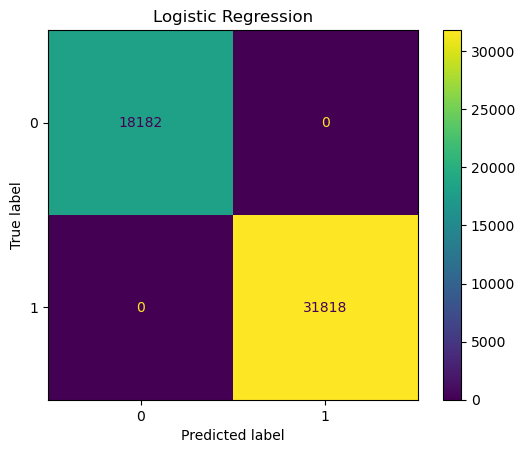


Random Forest
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
ROC-AUC: 1.0


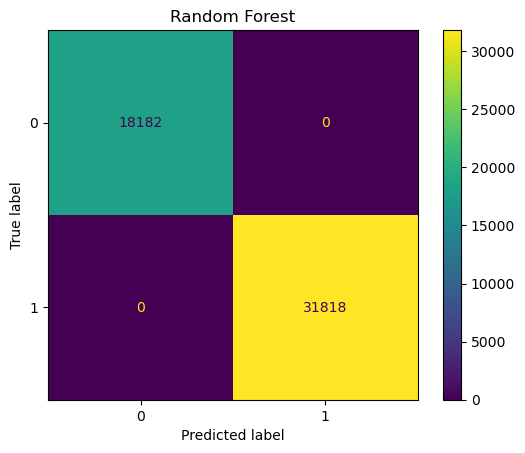


Gradient Boosting
Accuracy: 1.0
Recall: 1.0
Precision: 1.0
ROC-AUC: 1.0


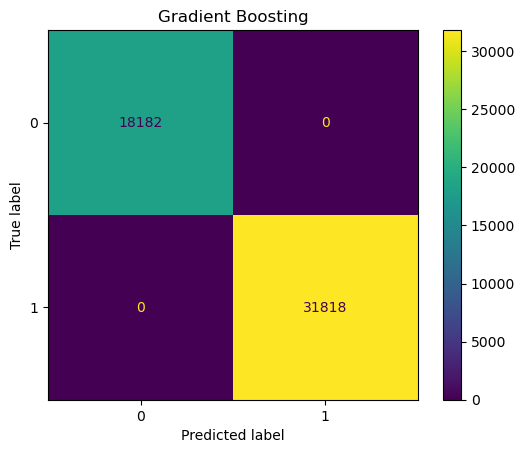

In [8]:
# --- 5) Modeling ---
def eval_model(name, model):
    pipe = Pipeline([("prep", preprocess), ("model", model)])
    pipe.fit(X_train, y_train)

    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:,1]

    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, preds))
    print("Recall:", recall_score(y_test, preds))
    print("Precision:", precision_score(y_test, preds))
    print("ROC-AUC:", roc_auc_score(y_test, probs))

    ConfusionMatrixDisplay.from_predictions(y_test, preds)
    plt.title(name)
    plt.show()

    return pipe

pipes = {}
pipes["Logistic Regression"] = eval_model(
    "Logistic Regression",
    LogisticRegression(max_iter=2000, class_weight="balanced")
)

pipes["Random Forest"] = eval_model(
    "Random Forest",
    RandomForestClassifier(n_estimators=400, class_weight="balanced", random_state=RANDOM_STATE)
)

pipes["Gradient Boosting"] = eval_model(
    "Gradient Boosting",
    GradientBoostingClassifier(random_state=RANDOM_STATE)
)


In [9]:
# --- 8) Explainability: feature importance (tree models) + coefficients (logistic) ---

def get_feature_names(preprocessor):
    # Build readable feature names after one-hot encoding
    num_features = preprocessor.transformers_[0][2]
    cat_pipe = preprocessor.transformers_[1][1]
    cat_features = preprocessor.transformers_[1][2]
    ohe = cat_pipe.named_steps["onehot"]
    cat_names = ohe.get_feature_names_out(cat_features)
    return np.concatenate([np.array(num_features, dtype=object), cat_names])

def plot_top_features(names, values, title, top_n=20):
    idx = np.argsort(np.abs(values))[::-1][:top_n]
    plt.figure()
    plt.barh(np.array(names)[idx][::-1], np.array(values)[idx][::-1])
    plt.title(title)
    plt.xlabel("Importance (absolute scale)")
    plt.tight_layout()
    plt.show()

# Choose best model by ROC-AUC (fall back to Random Forest if needed)
best_model_name = results_df.iloc[0]["model"]
best_pipe = trained[best_model_name]
print("Best model:", best_model_name)

# Fit preprocessor alone to get feature names
best_pre = best_pipe.named_steps["preprocess"]
feature_names = get_feature_names(best_pre)

model = best_pipe.named_steps["model"]

if hasattr(model, "feature_importances_"):
    importances = model.feature_importances_
    plot_top_features(feature_names, importances, f"Top features — {best_model_name}", top_n=25)
elif hasattr(model, "coef_"):
    coefs = model.coef_.ravel()
    plot_top_features(feature_names, coefs, f"Top coefficients — {best_model_name}", top_n=25)
else:
    print("Model does not expose feature_importances_ or coef_.")


NameError: name 'results_df' is not defined

In [ ]:
# --- 9) Optional: SHAP (if installed) ---
# SHAP can provide very clear explanations, but it may not be installed everywhere.
# This section is optional and will auto-skip if SHAP isn't available.

try:
    import shap  # type: ignore

    print("SHAP version:", shap.__version__)
    shap.initjs()

    # Transform data for SHAP
    X_train_trans = best_pre.transform(X_train)
    X_test_trans = best_pre.transform(X_test)

    # SHAP explainers differ by model type
    model = best_pipe.named_steps["model"]

    if hasattr(model, "predict_proba") and hasattr(model, "feature_importances_"):
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_test_trans)
        # Binary classification: use class 1 if list
        sv = shap_values[1] if isinstance(shap_values, list) else shap_values
        shap.summary_plot(sv, features=X_test_trans, feature_names=feature_names, show=True)
    else:
        # Generic explainer (can be slower)
        explainer = shap.Explainer(model, X_train_trans, feature_names=feature_names)
        shap_values = explainer(X_test_trans)
        shap.summary_plot(shap_values, show=True)

except Exception as e:
    print("SHAP not available or failed to run. Skipping. Reason:", str(e))

In [ ]:
# --- 10) Optional: Cross-validation on best model (quick check) ---
best_estimator = Pipeline(steps=[("preprocess", preprocess), ("model", best_pipe.named_steps["model"])])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
auc_scores = cross_val_score(best_estimator, X, y, cv=cv, scoring="roc_auc")

print("CV ROC-AUC scores:", auc_scores)
print("Mean ROC-AUC:", auc_scores.mean().round(4), "Std:", auc_scores.std().round(4))